In [76]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

## Merge metadata

In [2]:
amos = pd.read_csv("/data_analysis/amos/amos_metadata_def.csv")
totalseg = pd.read_csv("/data_analysis/totalseg/totalseg_metadata_def.csv")

In [33]:
meta = []
summary = json.load(open("/experiments_Swin-UNETR/validation_dice_calculation/validation_results_per_fold/summary_cross_val.json"))

for _, row in tqdm(amos.iterrows()):
    id = str(row['amos_id'])
    id = 'amos_'+'0'*(4 - len(id))+id
    sex = str(row["Patient's Sex"]).lower()
    age = int(row["Patient's Age"][:-1])
    manufacturer = str(row['Manufacturer']).lower()

    for case in summary['metric_per_case']:
        if case['prediction_file'].split('/')[-1].split('.')[0] == id:
            dice = list(case['metrics'].values())

            results = [id, sex, age, manufacturer]

            for dice_organ in dice:
                results.append(dice_organ)
    
            results.append(np.nanmean(dice))
    
            meta.append(results)

for _, row in tqdm(totalseg.iterrows()):
    id = str(row['image_id'])
    sex = str(row["gender"]).lower()
    age = int(row["age"])
    manufacturer = str(row['manufacturer']).lower()

    for case in summary['metric_per_case']:
        if case['prediction_file'].split('/')[-1].split('.')[0] == id:
            dice = list(case['metrics'].values())

            results = [id, sex, age, manufacturer]

            for dice_organ in dice:
                results.append(dice_organ)
    
            results.append(np.nanmean(dice))
    
            meta.append(results)

272it [00:00, 1448.08it/s]
378it [00:00, 1468.22it/s]


In [34]:
organs = [
    "Spleen",
    "Right Kidney",
    "Left Kidney",
    "Gallbladder",
    "Esophagus",
    "Liver",
    "Stomach",
    "Aorta",
    "Inferior Vena Cava",
    "Pancreas",
    "Right Adrenal Gland",
    "Left Adrenal Gland",
    "mean dice"
]

columns=['id', 'sex', 'age', 'manufacturer']

for organ in organs:
    columns.append(organ.lower())

In [37]:
pd.DataFrame(meta, columns=columns).to_csv("/data_analysis/swin_merged_metadata_def.csv", index=False)

## Statistical Analysis

In [77]:
data = pd.read_csv("/data_analysis/swin_merged_metadata_def.csv")

### Sex

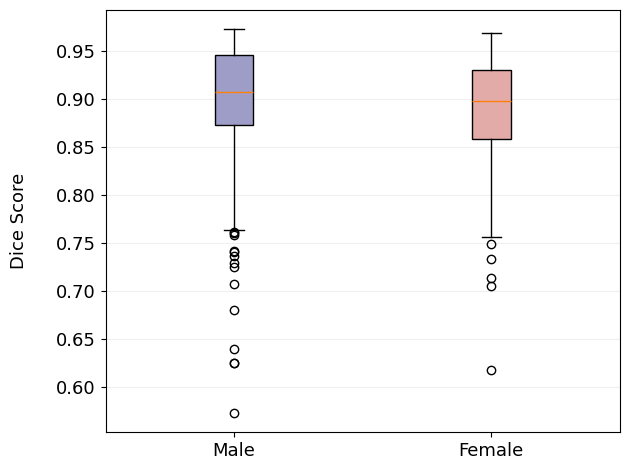

In [75]:
fontsize = 13

fig, ax = plt.subplots()

colors = met_brew(name="Cassatt1", n=2, brew_type="colorblind")

bplot = plt.boxplot([data.query("sex == 'm'")['mean dice'], data.query("sex == 'f'")['mean dice']], patch_artist=True)
plt.xticks([1, 2], ['Male', 'Female'], fontsize=fontsize)
plt.ylabel('Dice Score', fontsize=fontsize, labelpad=20)
plt.grid(alpha=0.2, axis='y')
plt.yticks(fontsize=fontsize)

for c, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[c-1])

plt.tight_layout()

plt.show()

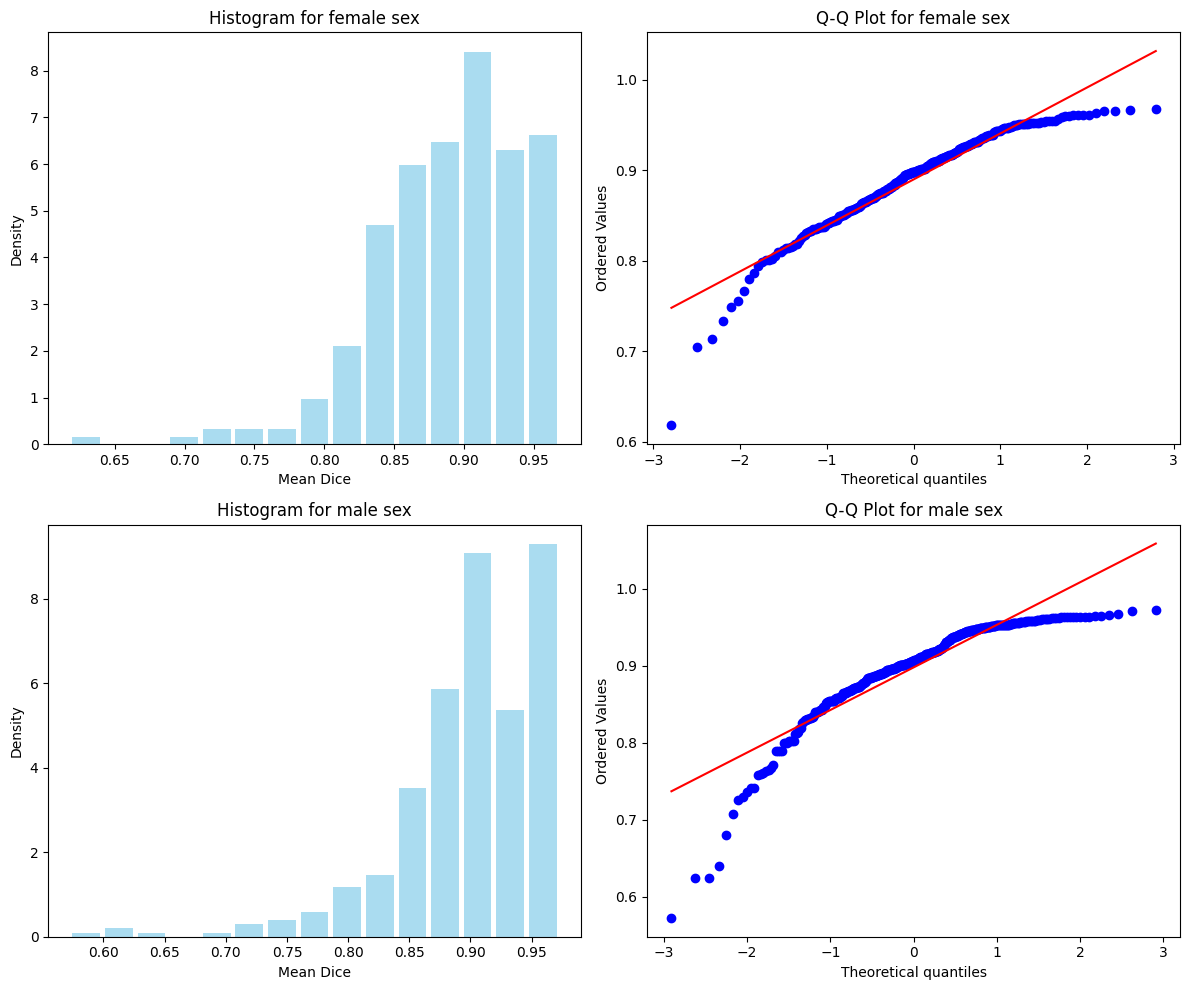

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for i, sex in enumerate(['f', 'm']):
    title_name = 0
    if sex == 'f': title_name = 'female'
    else: title_name = 'male'
    sex_data = data[data['sex'] == sex]['mean dice']
    # Histogram
    axes[i, 0].hist(sex_data, bins=15, color='skyblue', alpha=0.7, rwidth=0.85, density=True)
    axes[i, 0].set_title(f'Histogram for {title_name} sex')
    axes[i, 0].set_xlabel('Mean Dice')
    axes[i, 0].set_ylabel('Density')

    # Q-Q plot
    stats.probplot(sex_data, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'Q-Q Plot for {title_name} sex')
    
    plt.tight_layout()

In [43]:
female_data = data[data['sex'] == 'f']['mean dice']
male_data = data[data['sex'] == 'm']['mean dice']

In [44]:
print(stats.shapiro(female_data))
print(stats.shapiro(male_data))

ShapiroResult(statistic=0.9305886448976407, pvalue=8.225935152825048e-10)
ShapiroResult(statistic=0.8512722906770358, pvalue=1.2783040504864947e-18)


The data is not normally distributed, as demonstrated by both the Shapiro-Wilk test and the histogram, so we will use the Mann-Whitney U rank test 

In [45]:
stats.mannwhitneyu(female_data, male_data)

MannwhitneyuResult(statistic=44030.0, pvalue=0.0035289980958100446)

There is a statistically significant difference in both sex groups with a reasonable degree of confidence.

### Age

In [47]:
data['age_bin'] = pd.cut(data['age'], bins=[10, 40, 60, 80, 101], right=False, labels=['10-39', '40-59', '60-79', '80-99'])

# Grouping the data by age_bin only and calculating mean 'mean dice'
age_grouped = data.groupby('age_bin').agg({
    'mean dice': ['mean', 'std', 'count']
}).reset_index()

# Simplifying column names
age_grouped.columns = ['Age Bin', 'Mean Dice', 'STD Dice', 'Count']

age_grouped


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,Age Bin,Mean Dice,STD Dice,Count
0,10-39,0.884161,0.046722,90
1,40-59,0.889768,0.059123,241
2,60-79,0.903710,0.053375,269
3,80-99,0.889331,0.072970,50


In [48]:
# Extracting mean dice values for each age bin to perform ANOVA
groups = [data['mean dice'][data['age_bin'] == bin] for bin in age_grouped['Age Bin']]

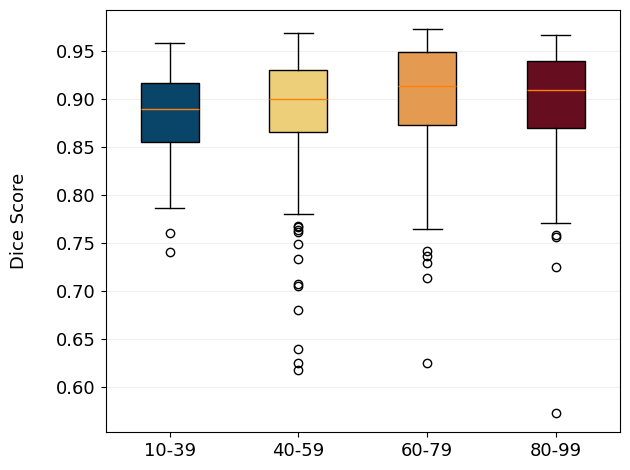

In [49]:
fontsize = 13

fig, ax = plt.subplots()

colors = met_brew(name="Navajo", n=4, brew_type="colorblind")
colors = [colors[3], colors[2], colors[1], colors[0]]

bplot = plt.boxplot([*groups], patch_artist=True)
plt.xticks([1, 2, 3, 4], ['10-39', '40-59', '60-79', '80-99'], fontsize=fontsize)
plt.ylabel('Dice Score', fontsize=fontsize, labelpad=20)
plt.grid(alpha=0.2, axis='y')
plt.yticks(fontsize=fontsize)

for c, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[c])

plt.tight_layout()

plt.show()

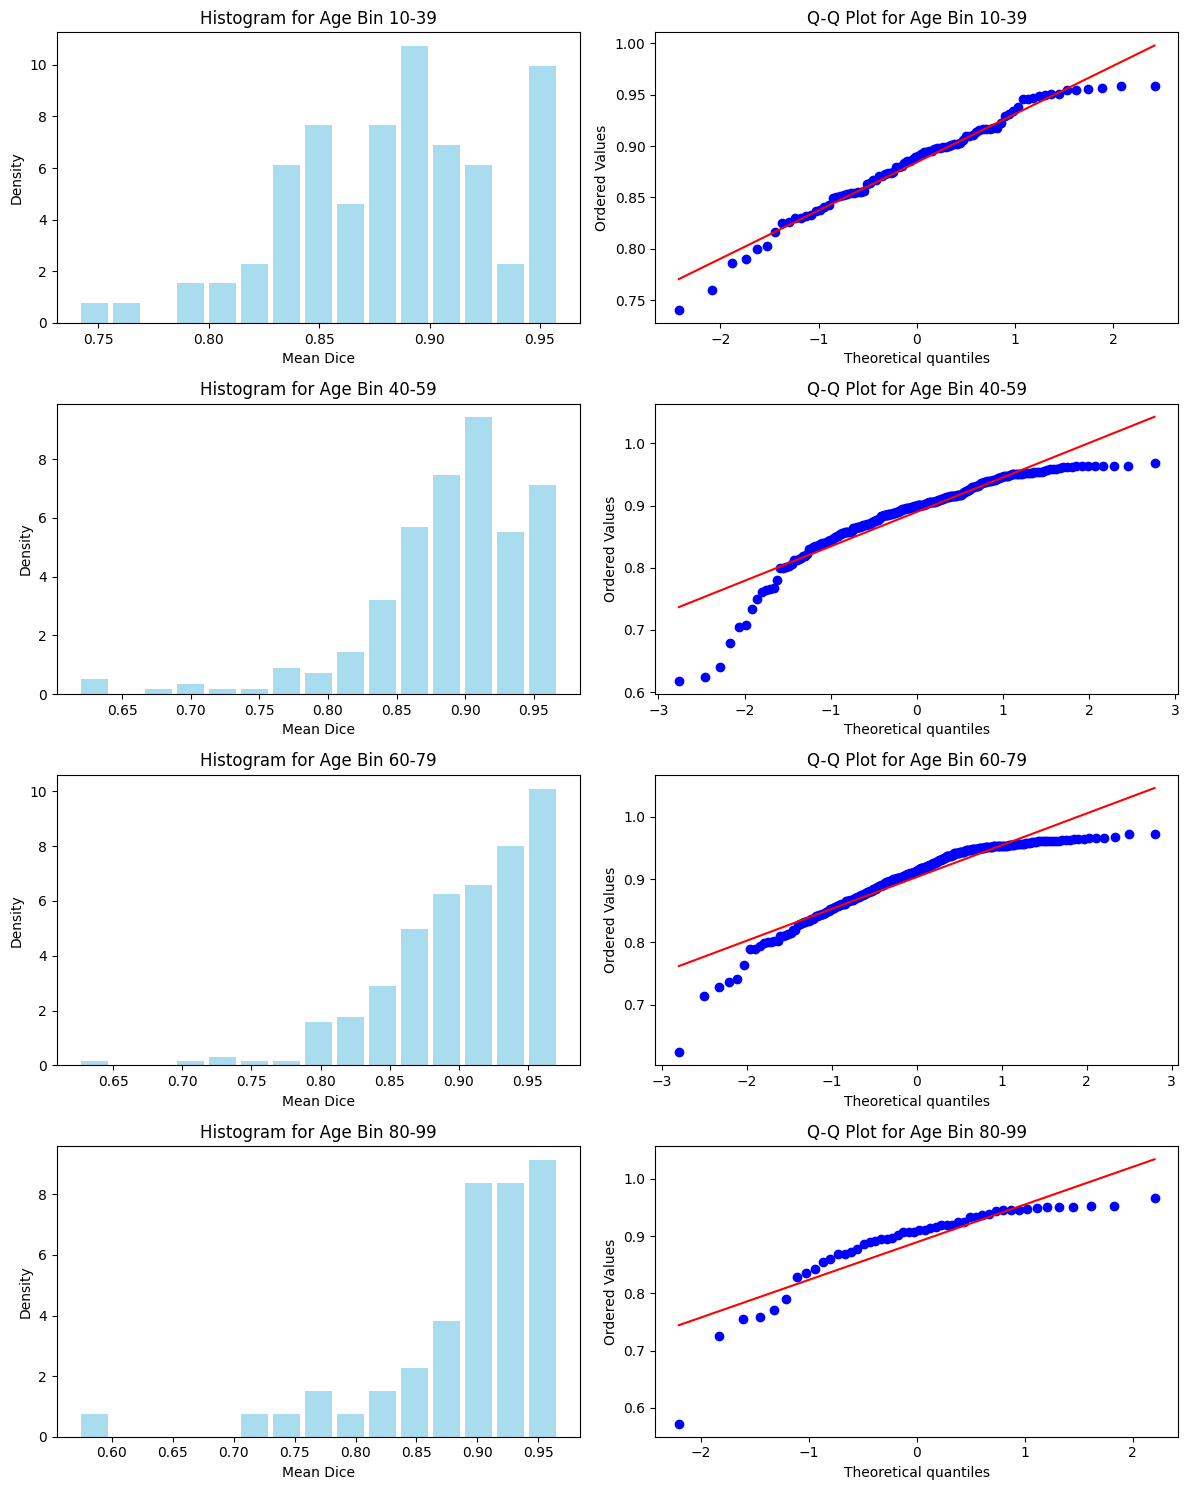

In [50]:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, axes = plt.subplots(nrows=len(age_grouped), ncols=2, figsize=(12, 15))
bins = age_grouped['Age Bin']

for i, bin in enumerate(bins):
    # Histogram
    axes[i, 0].hist(groups[i], bins=15, color='skyblue', alpha=0.7, rwidth=0.85, density=True)
    axes[i, 0].set_title(f'Histogram for Age Bin {bin}')
    axes[i, 0].set_xlabel('Mean Dice')
    axes[i, 0].set_ylabel('Density')

    # Q-Q plot
    stats.probplot(groups[i], dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'Q-Q Plot for Age Bin {bin}')

plt.tight_layout()

plt.show()


In [51]:
for group in groups:
    print(stats.shapiro(group))

ShapiroResult(statistic=0.9687082531672832, pvalue=0.028701059669155225)
ShapiroResult(statistic=0.8661712216066954, pvalue=1.1335912377058426e-13)
ShapiroResult(statistic=0.8919273167008158, pvalue=6.304026939859321e-13)
ShapiroResult(statistic=0.7823455975365334, pvalue=3.5184672545010716e-07)


In [52]:
stats.kruskal(*groups)

KruskalResult(statistic=19.09061646189525, pvalue=0.0002618535089207412)

In [53]:
import scikit_posthocs as sp

sp.posthoc_dunn(data, val_col='mean dice', group_col='age_bin', p_adjust='bonferroni')

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,10-39,40-59,60-79,80-99
10-39,1.000000,0.525172,0.000427,0.454793
40-59,0.525172,1.000000,0.012669,1.000000
60-79,0.000427,0.012669,1.000000,1.000000
80-99,0.454793,1.000000,1.000000,1.000000


### Manufacturer

In [79]:
data = data.replace('ge medical systems', 'ge')

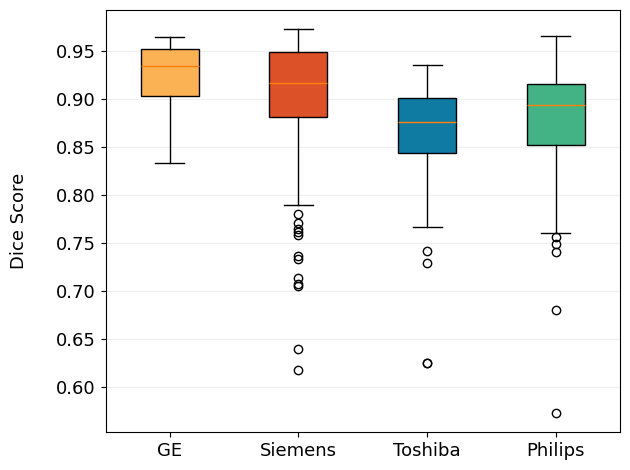

In [80]:
fontsize = 13

fig, ax = plt.subplots()

colors = met_brew(name="Egypt", n=4, brew_type="colorblind")

values = list(data.groupby('manufacturer')['mean dice'])

bplot = plt.boxplot([brand[1] for brand in [values[0], values[2], values[3], values[1]]], patch_artist=True)
plt.xticks([1, 2, 3, 4], ['GE', 'Siemens', 'Toshiba', 'Philips'], fontsize=fontsize)
plt.ylabel('Dice Score', fontsize=fontsize, labelpad=20)
plt.grid(alpha=0.2, axis='y')
plt.yticks(fontsize=fontsize)

for c, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[c-1])

plt.tight_layout()

plt.show()

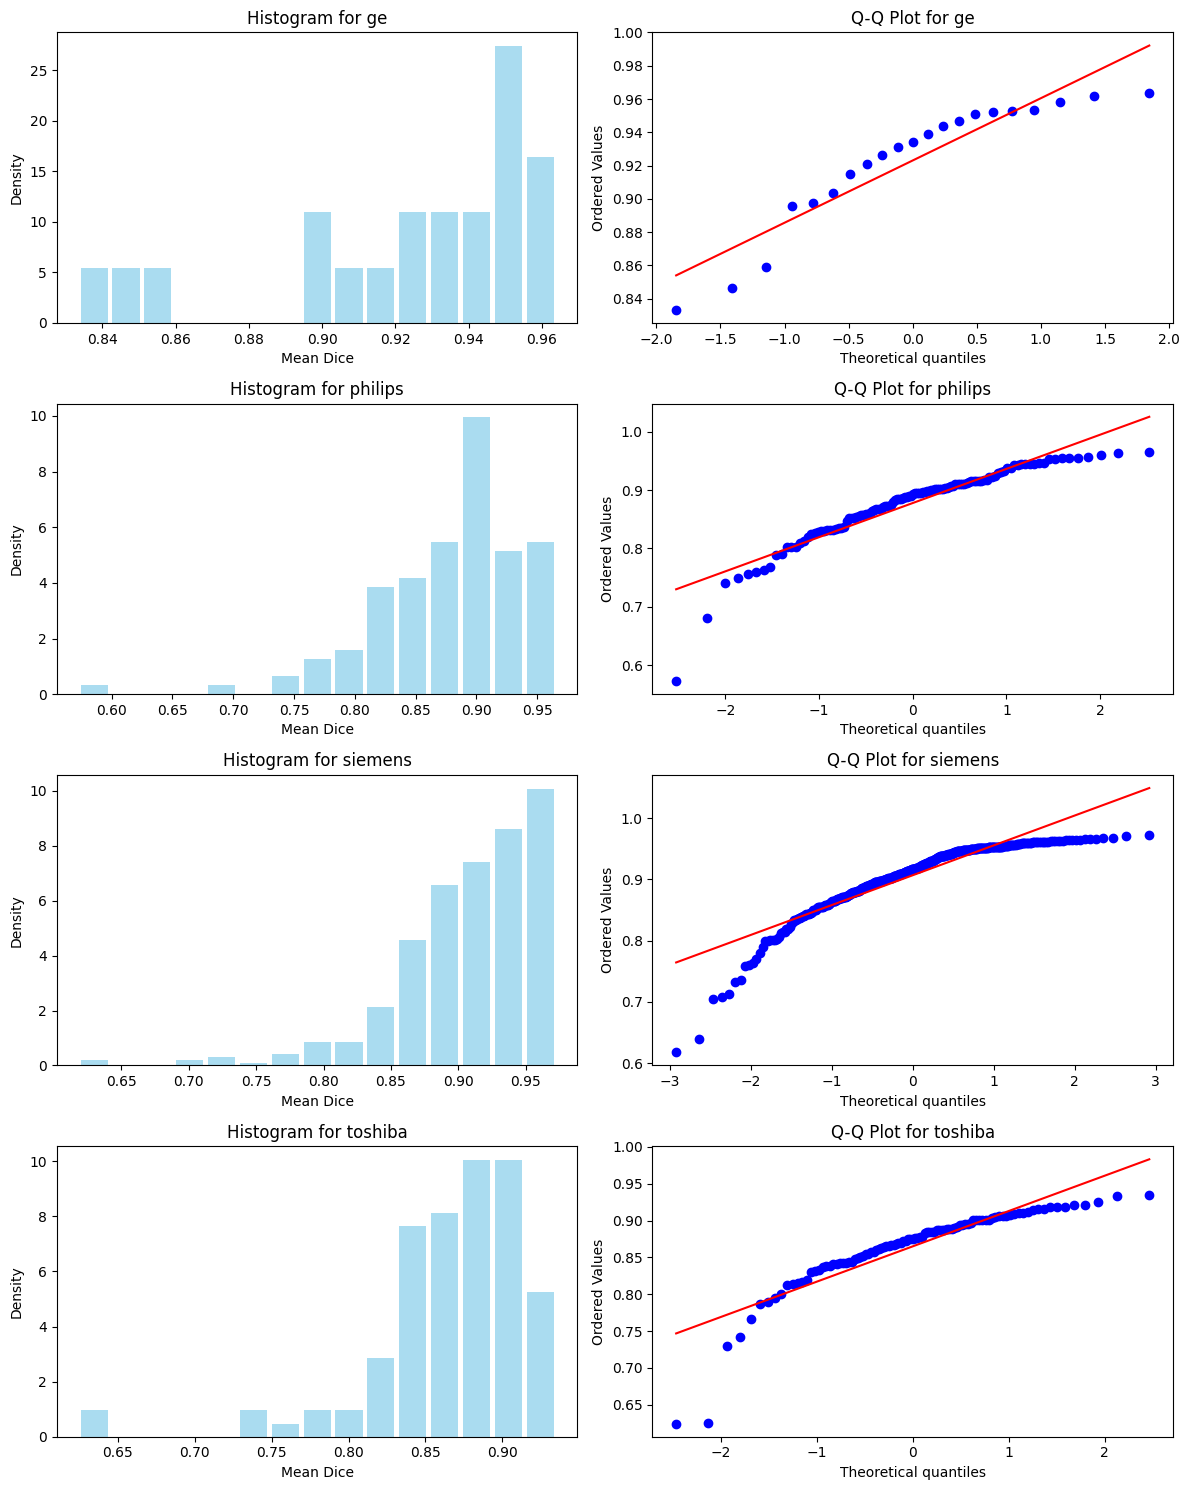

In [81]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 15))

for i, manufacturer in enumerate(['ge', 'philips', 'siemens', 'toshiba']):

    manufacturer_data = data[data['manufacturer'] == manufacturer]['mean dice']
    
    # Histogram
    axes[i, 0].hist(manufacturer_data, bins=15, color='skyblue', alpha=0.7, rwidth=0.85, density=True)
    axes[i, 0].set_title(f'Histogram for {manufacturer}')
    axes[i, 0].set_xlabel('Mean Dice')
    axes[i, 0].set_ylabel('Density')

    # Q-Q plot
    stats.probplot(manufacturer_data, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'Q-Q Plot for {manufacturer}')
    
    plt.tight_layout()

In [82]:
for i, manufacturer in enumerate(['ge', 'philips', 'siemens', 'toshiba']):

    manufacturer_data = data[data['manufacturer'] == manufacturer]['mean dice']
    print(stats.shapiro(manufacturer_data))

ShapiroResult(statistic=0.8635982028282124, pvalue=0.007351774098241388)
ShapiroResult(statistic=0.8942738493636804, pvalue=1.1144516633085924e-07)
ShapiroResult(statistic=0.858745086273947, pvalue=1.6012497798150293e-18)
ShapiroResult(statistic=0.8132493259571533, pvalue=5.634581919375989e-10)


In [83]:
stats.kruskal(*[data['mean dice'][data['manufacturer'] == m] for m in ['siemens', 'philips', 'ge', 'toshiba']])

KruskalResult(statistic=85.4659244484476, pvalue=2.061303983950592e-18)

In [85]:
sp.posthoc_dunn(df, val_col='mean dice', group_col='manufacturer', p_adjust='bonferroni')

,ge,philips,siemens,toshiba
ge,1.000000,1.173207e-03,9.686153e-01,2.848433e-06
philips,0.001173,1.000000e+00,3.213658e-07,9.533156e-02
siemens,0.968615,3.213658e-07,1.000000e+00,5.884035e-15
toshiba,0.000003,9.533156e-02,5.884035e-15,1.000000e+00


In [61]:
manufacturer_grouped = data.groupby('manufacturer').agg({
    'mean dice': ['mean', 'std', 'count']
}).reset_index()

manufacturer_grouped.columns = ['Manufacturer', 'Mean Dice', 'STD Dice', 'Count']

manufacturer_grouped

,Manufacturer,Mean Dice,STD Dice,Count
0,ge,0.923068,0.038130,21
1,philips,0.877659,0.061334,119
2,siemens,0.906885,0.052351,399
3,toshiba,0.864975,0.052616,101


### Dataset Ranking

In [63]:
import pandas as pd
from scipy.stats import spearmanr


data = {
    "Anatomical_Structure": ["Spl", "RKid", "LKid", "Gall", "Eso", "Liv", "Sto", "Aor", "IVC", "Pan", "RAG", "LAG"],
    "BTCV_Dice": [90.66,89.47,87.49,68.89,76.41,95.52,90.46,90.77,86.20,80.20,68.89,68.51],
    "AMOS_Dice": [95.57,94.76,94.34,83.00,79.20,96.93,89.90,92.91,87.18,82.61,72.35,71.37],
    "TotalSeg_Dice": [96.89,96.05,95.59,83.38,86.77,98.32,93.73,96.62,92.80,89.06,84.17,84.43]
}

df = pd.DataFrame(data)

df['BTCV_Rank'] = df['BTCV_Dice'].rank(ascending=False)
df['AMOS_Rank'] = df['AMOS_Dice'].rank(ascending=False)
df['TotalSeg_Rank'] = df['TotalSeg_Dice'].rank(ascending=False)

btcv_amos_corr, btcv_amos_p = spearmanr(df['BTCV_Rank'], df['AMOS_Rank'])
btcv_totalseg_corr, btcv_totalseg_p = spearmanr(df['BTCV_Rank'], df['TotalSeg_Rank'])
amos_totalseg_corr, amos_totalseg_p = spearmanr(df['AMOS_Rank'], df['TotalSeg_Rank'])

btcv_totalseg_corr, btcv_totalseg_p, amos_totalseg_corr, amos_totalseg_p, btcv_amos_corr, btcv_amos_p

(0.9492133645984593,
 2.4427417276402135e-06,
 0.9020979020979022,
 5.9978574465377e-05,
 0.8931712471313916,
 9.135974793210101e-05)

In [64]:
comparison_table = df[['Anatomical_Structure', 'BTCV_Rank', 'AMOS_Rank', 'TotalSeg_Rank']].copy()

comparison_table['Average_Rank'] = comparison_table[['BTCV_Rank', 'AMOS_Rank', 'TotalSeg_Rank']].mean(axis=1)
comparison_table.sort_values(by='Average_Rank', inplace=True)

comparison_table.reset_index(drop=True, inplace=True)
comparison_table

,Anatomical_Structure,BTCV_Rank,AMOS_Rank,TotalSeg_Rank,Average_Rank
0,Liv,1.0,1.0,1.0,1.000000
1,Spl,3.0,2.0,2.0,2.333333
2,Aor,2.0,5.0,3.0,3.333333
3,RKid,5.0,3.0,4.0,4.000000
4,LKid,6.0,4.0,5.0,5.000000
5,Sto,4.0,6.0,6.0,5.333333
6,IVC,7.0,7.0,7.0,7.000000
7,Pan,8.0,9.0,8.0,8.333333
8,Eso,9.0,10.0,9.0,9.333333
9,Gall,10.5,8.0,12.0,10.166667
